# Transfer learning

## Download pre-trained weight(if needed) and model

In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
# download pre-trained weight for inception v3 model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-08-28 06:53:30--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 66.102.1.128, 64.233.167.128, 74.125.133.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|66.102.1.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  91.0MB/s    in 0.9s    

2020-08-28 06:53:31 (91.0 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [3]:
# import inceptiontionV3 model 
from tensorflow.keras.applications.inception_v3 import InceptionV3

trained_weight_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(include_top=False, # dont include the last FC layer
                                input_shape=(150, 150, 3), # only need to be given if include_top=False
                                weights=None) # load downloaded weights later

pre_trained_model.load_weights(trained_weight_file)

## Freeze layers

In [4]:
# we want to train only the top layers (which were randomly initialized, not with the pre-trained weights)
# freeze all InceptionV3 layers
for layer in pre_trained_model.layers:
    layer.trainable = False


In [5]:
# take a look at the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

As we can see, InceptionV3 is a really deep CNN and has a lot of parameters. But here we have removed the top layer/last layer and freezed all the other layers, so the trainable parameters are 0.

## Add the last layer (trainable for our goal)

In [6]:
# add 'mixed7' layer (7*7 concatenate layer) as the last layer
last_layer = pre_trained_model.get_layer('mixed7')
print("Last layer output is: ", last_layer.output_shape)
last_output = last_layer.output # this is not the last FC layer, this is the last of Convolutional layer

Last layer output is:  (None, 7, 7, 768)


## Create Optimizer and train

In [7]:
from tensorflow.keras.optimizers import RMSprop

# Flatten
x = layers.Flatten()(last_output)
# Dense
x = layers.Dense(1024, activation='relu')(x)
# Dropout 
x = layers.Dropout(0.2)(x)
# Sigmoid Classifier
prediction = layers.Dense(1, activation='sigmoid')(x)
# put them all together
model = keras.Model(inputs = pre_trained_model.input, outputs = prediction)

model.compile(optimizer = RMSprop(lr=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [8]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from keras.preprocessing.image import ImageDataGenerator
import zipfile

zip_path = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(zip_path, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2020-08-28 06:53:36--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.140.128, 173.194.76.128, 64.233.184.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.140.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  71.7MB/s    in 0.9s    

2020-08-28 06:53:37 (71.7 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [9]:
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats') 
train_dogs_dir = os.path.join(train_dir, 'dogs') 
validation_cats_dir = os.path.join(validation_dir, 'cats') 
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

In [10]:
print("total number of train cats images: ", len(train_cat_fnames))
print("total number of train dogs images: ", len(train_dog_fnames))

total number of train cats images:  1000
total number of train dogs images:  1000


In [11]:
train_datagen = ImageDataGenerator(
    rescale = 1.0/255.,
    rotation_range = 30,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True
)

validation_datagen = ImageDataGenerator(   # here validation data set -> test set so it should not be augmented (except rescale)
    rescale = 1./255. 
)

# Flow from directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size = 20,
    class_mode = 'binary',
    target_size = (150, 150)
)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    batch_size = 20,
    class_mode = 'binary',
    target_size = (150, 150)
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [14]:
history = model.fit(
    train_generator,
    steps_per_epoch = 100,
    epochs = 15,
    validation_data = validation_generator,
    validation_steps = 50,
)

Epoch 1/15
100/100 [==============================] - 24s 244ms/step - loss: 0.3055 - accuracy: 0.8790 - val_loss: 0.1179 - val_accuracy: 0.9530
Epoch 2/15
100/100 [==============================] - 23s 227ms/step - loss: 0.2068 - accuracy: 0.9230 - val_loss: 0.0966 - val_accuracy: 0.9620
Epoch 3/15
100/100 [==============================] - 23s 234ms/step - loss: 0.1704 - accuracy: 0.9385 - val_loss: 0.0902 - val_accuracy: 0.9720
Epoch 4/15
100/100 [==============================] - 23s 226ms/step - loss: 0.1504 - accuracy: 0.9485 - val_loss: 0.1087 - val_accuracy: 0.9670
Epoch 5/15
100/100 [==============================] - 23s 232ms/step - loss: 0.1497 - accuracy: 0.9575 - val_loss: 0.1514 - val_accuracy: 0.9600
Epoch 6/15
100/100 [==============================] - 23s 225ms/step - loss: 0.1661 - accuracy: 0.9520 - val_loss: 0.1129 - val_accuracy: 0.9680
Epoch 7/15
100/100 [==============================] - 23s 230ms/step - loss: 0.1611 - accuracy: 0.9515 - val_loss: 0.1064 - val_ac

## Result Visualization

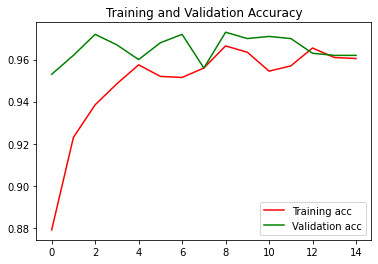

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training acc')
plt.plot(epochs, val_acc, 'g', label = 'Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()